# Cycling Network Analysis – Graz

Course: GIS Analysis Techniques 2  
Group: 1  
Authors: ...  


In [ ]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import RectBivariateSpline
#import json
from shapely.geometry import Point 
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import gc, time
import subprocess

print(sys.executable) #environment sanity check


c:\Users\micha\Uni1\GIS Analysetechniken 2\Gis Anal2\.venv\Scripts\python.exe


In [3]:
## Data ##
place = "Graz, Austria"
main_crs = "EPSG:31256"

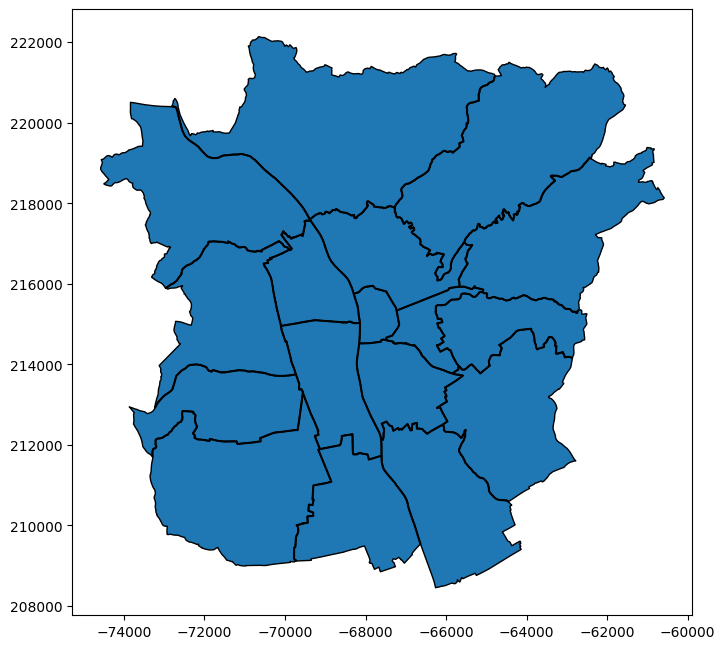

In [4]:
## city and districts
gdf_boundaries = ox.features_from_place(
    place,
    tags={"boundary": "administrative"}
)

df_districts = gdf_boundaries[gdf_boundaries["admin_level"] == "9"]
df_districts = df_districts.to_crs(main_crs)

df_districts.plot(edgecolor="black", figsize=(8, 8))
plt.show()

In [5]:
## main University 
poi = [
    "Universitätsplatz 3, 8010 Graz",      
    "Rechbauerstraße 12, 8010 Graz",      
    "Neue Stiftingtalstraße 6, 8010 Graz",
    "Leonhardstraße 15, 8010 Graz",        
    "Körblergasse 126, 8010 Graz",        
    "Alte Poststraße 149, 8010 Graz",
    "Hasnerplatz 12, 8010 Graz",
    "Inffeldgasse 25, 8010 Graz"   
]

coords = [ox.geocode(addr) for addr in poi]
uni_points = [Point(lon, lat) for lat, lon in coords]

graz_unis = gpd.GeoDataFrame(
    {'name': poi},
    geometry=uni_points,
    crs="EPSG:4326"
).to_crs(main_crs)

#graz_unis.plot(figsize=(10,10), color="red", markersize=50, alpha=0.9)
#plt.show()

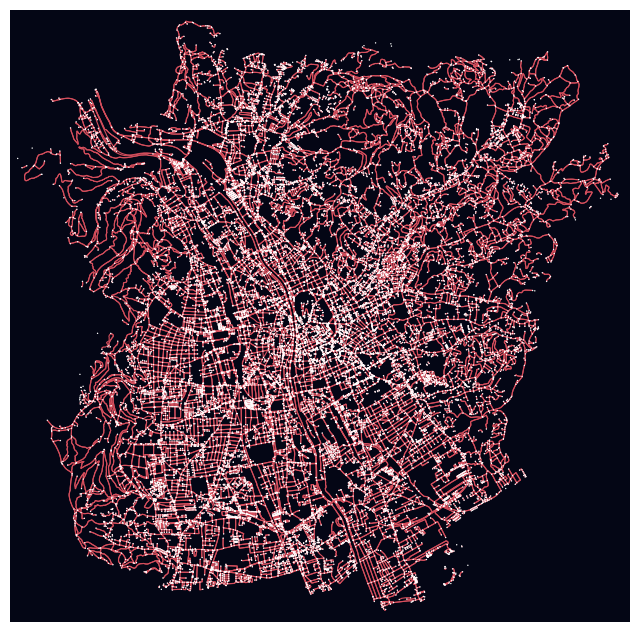

In [6]:
## Road network
G = ox.graph_from_place(
    place,
    network_type="bike",     
    simplify=True,
    retain_all=True           
)

G = ox.project_graph(G, to_crs=main_crs)

G_simple = nx.DiGraph(G)

#stats_json = ox.stats.basic_stats(G)
#print(json.dumps(stats_json, indent=2))

fig, ax = ox.plot_graph(
    G,
    node_size=1,              
    bgcolor="#040615",
    edge_color="#d44e5c",
    edge_linewidth=0.8
)
plt.show()

In [7]:
## Tram network
tram = ox.graph_from_place(
    place,
    custom_filter='["railway"="tram"]["service"!="yard"]["service"!="siding"]["service"!="spur"]',
    simplify=True,
    retain_all=True
)

tram = ox.project_graph(tram, to_crs=main_crs)

# to remove isolated edges
comps = list(nx.weakly_connected_components(tram)) 
tram_main = max(comps, key=len) 
tram_main = tram.subgraph(tram_main).copy()

#stats_json = ox.stats.basic_stats(tram_main)
#print(json.dumps(stats_json, indent=2))

#fig, ax = ox.plot_graph(
#    tram_main,
#    node_size=5,
#    bgcolor="#040615",
#    edge_color="#00d4ff",
#    edge_linewidth=1.2
#)

In [ ]:
# DEM
#path = Path(r"C:\Users\kosch\Desktop\final-project-group1-cycling-network\data_dem")
#FIX_NODATA = -9999.0

#raw_dirs = [path / s for s in ("352x20x","352x21x","353x20x","353x21x","354x20x","354x21x")]

#tiff = sorted({p for d in raw_dirs if d.exists() for p in d.rglob("*.tif")})

#city_geom = df_districts.to_crs(main_crs).dissolve().geometry.iloc[0]

# fixing
#fixed_dir = path / "_fixed_tiles"
#fixed_dir.mkdir(exist_ok=True)

#fixed_tifs = []
#for p in tiff:
#    out_p = fixed_dir / f"{p.parent.name}__{p.name}"
#
#    if not out_p.exists():
#        with rasterio.open(p) as src:
#            data = src.read(1).astype("float32")
#            data[data < -1e20] = FIX_NODATA

#            meta = src.meta.copy()
#            meta.update(dtype="float32", nodata=FIX_NODATA, count=1)

#        with rasterio.open(out_p, "w", **meta) as dst:
#            dst.write(data, 1)

#    fixed_tifs.append(out_p)

# mosaic
#srcs = [rasterio.open(p) for p in fixed_tifs]
#try:
#    mosaic, mosaic_transform = merge(srcs, nodata=FIX_NODATA, dtype="float32")
#    meta = srcs[0].meta.copy()
#finally:
#    for s in srcs:
#        s.close()

#meta.update(
#    height=mosaic.shape[1],
#    width=mosaic.shape[2],
#    transform=mosaic_transform,
#    dtype="float32",
#    nodata=FIX_NODATA,
#    count=mosaic.shape[0],
#)

# crs
#dst_transform, dst_width, dst_height = calculate_default_transform(
#    meta["crs"], main_crs, meta["width"], meta["height"],
#    *rasterio.transform.array_bounds(meta["height"], meta["width"], meta["transform"])
#)

#reproj = np.empty((meta["count"], dst_height, dst_width), dtype="float32")
#for i in range(meta["count"]):
#    reproject(
#        source=mosaic[i],
#        destination=reproj[i],
#        src_transform=meta["transform"],
#        src_crs=meta["crs"],
#        dst_transform=dst_transform,
#        dst_crs=main_crs,
#        resampling=Resampling.bilinear,
#        src_nodata=FIX_NODATA,
#        dst_nodata=FIX_NODATA,
#    )

#reproj_meta = meta.copy()
#reproj_meta.update(crs=main_crs, transform=dst_transform, width=dst_width, height=dst_height)

# clip and save
#with rasterio.io.MemoryFile() as mf:
#    with mf.open(**reproj_meta) as ds:
#        ds.write(reproj)

#        out_img, out_transform = mask(ds, [city_geom], crop=True, nodata=FIX_NODATA)

#        out_meta = ds.meta.copy()
#        out_meta.update(height=out_img.shape[1], width=out_img.shape[2], transform=out_transform, nodata=FIX_NODATA)

#final_path = Path("..") / "data" / "processed" / "dem_graz.tif"
#with rasterio.open(final_path, "w", **out_meta) as dst:
#    dst.write(out_img)



In [43]:
## Preprocessing ##

In [8]:
## snapping
nodes, node_dists = ox.distance.nearest_nodes(
    G,
    X=graz_unis.geometry.x.to_numpy(),
    Y=graz_unis.geometry.y.to_numpy(),
    return_dist=True
)

graz_unis["nearest_node"] = nodes
graz_unis["dist_to_node_m"] = node_dists

edges, edge_dists = ox.distance.nearest_edges(
    G,
    X=graz_unis.geometry.x.to_numpy(),
    Y=graz_unis.geometry.y.to_numpy(),
    return_dist=True
)

graz_unis["nearest_edge"] = edges
graz_unis["dist_to_edge_m"] = edge_dists

graz_unis_snapped = graz_unis.drop_duplicates(subset=["nearest_node"]).copy()

print(graz_unis[["name", "nearest_node", "dist_to_node_m"]])

                                  name  nearest_node  dist_to_node_m
0       Universitätsplatz 3, 8010 Graz    3871900100       55.232284
1        Rechbauerstraße 12, 8010 Graz    4113732444       28.696822
2  Neue Stiftingtalstraße 6, 8010 Graz     266012637       57.639884
3         Leonhardstraße 15, 8010 Graz   11808409633       42.454915
4          Körblergasse 126, 8010 Graz    1359825555       96.615832
5       Alte Poststraße 149, 8010 Graz   13384518939       13.708686
6            Hasnerplatz 12, 8010 Graz     773222019       44.120209
7           Inffeldgasse 25, 8010 Graz     882291834       71.830795


In [ ]:
##slope
#dem_path = Path("..") / "data" / "processed" / "dem_graz.tif"
#slope_path = Path("..") / "data" / "processed" / "slope_graz.tif"

#result = subprocess.run([
#        "gdaldem", "slope", str(dem_path), str(slope_path),
#        "-s", "1",                 
#        "-compute_edges",             
#        "-of", "GTiff",               
#        "-co", "COMPRESS=LZW",        
#        "-co", "TILED=YES"           
#    ], 
#    capture_output=True, 
#    text=True, 
#    timeout=300
#    )

In [ ]:
# Pre-compute distance maps for both length-based and weighted routing

warnings.filterwarnings('ignore')

print("="*60)
print("SETUP: Pre-computing distance maps for all routing analyses")
print("="*60)

# Filter districts to only valid polygons
valid_districts = []
for idx, district in df_districts.iterrows():
    geom = district.geometry
    if isinstance(geom, Polygon):
        valid_districts.append(district)
    elif isinstance(geom, MultiPolygon):
        valid_districts.append(district)

print(f"\nProcessing {len(valid_districts)} valid district polygons")

# Get all universities
all_uni_node_ids = graz_unis_snapped["nearest_node"].to_list()
print(f"Total universities: {len(all_uni_node_ids)}\n")

# Load slope data
print("Loading slope data...")
slope_path = "C:/Users/micha/Uni1/GIS Analysetechniken 2/endterm/slope_graz/slope_graz.tif"
use_slope = True
with rasterio.open(slope_path) as src:
    slope_data = src.read(1)
    slope_transform = src.transform
    slope_nodata = src.nodata
print(f"  Loaded slope raster: {slope_data.shape}")

# Identify tram edges
print("Identifying tram network edges...")
tram_edges = set()
for u, v in tram_main.edges():
    tram_edges.add((u, v))
    tram_edges.add((v, u))
print(f"  Found {len(tram_edges)} tram edges")

# Speed lookup function
def get_speed_from_edge(edge_data):
    if 'maxspeed' in edge_data:
        try:
            speed_str = edge_data['maxspeed']
            if isinstance(speed_str, list):
                speed_str = speed_str[0]
            if 'km/h' in str(speed_str):
                return float(str(speed_str).split()[0])
            else:
                return float(speed_str)
        except:
            pass
    
    highway_type = edge_data.get('highway', 'residential')
    default_speeds = {
        'motorway': 120, 'trunk': 100, 'primary': 80, 'secondary': 60,
        'tertiary': 50, 'residential': 30, 'living_street': 20,
        'pedestrian': 10, 'path': 15, 'cycleway': 25, 'track': 20,
    }
    
    if isinstance(highway_type, list):
        highway_type = highway_type[0]
    return default_speeds.get(highway_type, 50)

# Weighted cost function
def compute_weighted_cost(length_m, speed_kmh, has_tramway, slope_pct):
    time_cost = length_m / (speed_kmh / 3.6) if speed_kmh > 0 else length_m * 100
    speed_penalty = 1.0 + ((speed_kmh - 40) / 50.0) ** 2 if speed_kmh > 40 else 1.0
    tram_factor = 0.8 if has_tramway else 1.0
    slope_penalty = 1.0 + (slope_pct / 100.0) ** 2 if slope_pct > 0 else 1.0
    return time_cost * speed_penalty * tram_factor * slope_penalty

# Add weights to graph edges
print("\nAdding weighted costs to graph edges...")
if use_slope:
    print("  Pre-computing slope interpolator...")
    y_coords = np.arange(slope_data.shape[0])
    x_coords = np.arange(slope_data.shape[1])
    slope_interp = RectBivariateSpline(y_coords, x_coords, slope_data.astype(float))

edge_count = 0
for u, v, data in G_simple.edges(data=True):
    length = data.get('length', 100)
    speed = get_speed_from_edge(data)
    has_tram = (u, v) in tram_edges
    
    if use_slope:
        try:
            x_mid = (G_simple.nodes[u]['x'] + G_simple.nodes[v]['x']) / 2
            y_mid = (G_simple.nodes[u]['y'] + G_simple.nodes[v]['y']) / 2
            row, col = rasterio.transform.rowcol(slope_transform, x_mid, y_mid)
            
            if 0 <= row < slope_data.shape[0] and 0 <= col < slope_data.shape[1]:
                slope = float(slope_interp(row, col)[0][0])
                if np.isnan(slope) or slope == slope_nodata:
                    slope = 0.0
            else:
                slope = 0.0
        except:
            slope = 0.0
    else:
        slope = 0.0
    
    weighted_cost = compute_weighted_cost(length, speed, has_tram, slope)
    
    data['weighted_cost'] = weighted_cost
    data['speed_kmh'] = speed
    data['has_tramway'] = has_tram
    data['slope_pct'] = slope
    edge_count += 1

print(f"  Added weighted costs to {edge_count} edges")

# PRE-COMPUTE SHORTEST PATHS using Dijkstra (SINGLE-SOURCE, REVERSE DIRECTION)
print("\nPre-computing shortest path distances from each university...")
uni_distance_maps = {}

for uni_node in all_uni_node_ids:
    # Length-based Dijkstra (from university to all nodes)
    distances_length = nx.single_source_dijkstra_path_length(
        G_simple, source=uni_node, weight='length'
    )
    paths_length = nx.single_source_dijkstra_path(
        G_simple, source=uni_node, weight='length'
    )
    
    # Weighted cost Dijkstra (from university to all nodes)
    distances_weighted = nx.single_source_dijkstra_path_length(
        G_simple, source=uni_node, weight='weighted_cost'
    )
    paths_weighted = nx.single_source_dijkstra_path(
        G_simple, source=uni_node, weight='weighted_cost'
    )
    
    uni_distance_maps[uni_node] = {
        'distances_length': distances_length,
        'paths_length': paths_length,
        'distances_weighted': distances_weighted,
        'paths_weighted': paths_weighted
    }

print(f"  Pre-computed paths for {len(uni_distance_maps)} universities")

# Define optimized routing function (uses pre-computed paths only)
def find_nearest_uni_fast(node, uni_nodes, uni_distance_maps, weight_type='weighted_cost'):
    best_cost = float('inf')
    best_uni = None
    best_path = None
    
    if weight_type == 'weighted_cost':
        distances_key = 'distances_weighted'
        paths_key = 'paths_weighted'
    else:
        distances_key = f'distances_{weight_type}'
        paths_key = f'paths_{weight_type}'
    
    for uni_node in uni_nodes:
        if node in uni_distance_maps[uni_node][distances_key]:
            cost = uni_distance_maps[uni_node][distances_key][node]
            if cost < best_cost:
                best_cost = cost
                best_uni = uni_node
                best_path = uni_distance_maps[uni_node][paths_key][node]
    
    if best_uni is not None:
        return {
            'uni_node': best_uni,
            'cost': best_cost,
            'path': best_path
        }
    return None

print(f"\n{'='*60}")
print("Setup complete. All Dijkstra pre-computation done.")
print(f"{'='*60}\n")

SETUP: Pre-computing distance maps for all routing analyses

Processing 17 valid district polygons
Total universities: 8

Loading slope data...
  Loaded slope raster: (13668, 13993)
Identifying tram network edges...
  Found 323 tram edges

Adding weighted costs to graph edges...
  Pre-computing slope interpolator...
  Added weighted costs to 58328 edges

Pre-computing shortest path distances from each university...
  This uses nx.single_source_dijkstra_path_length() and nx.single_source_dijkstra_path()
  Running 8 Dijkstra calls (one per university) - ONLY ONCE
  Pre-computed paths for 8 universities

Setup complete. All Dijkstra pre-computation done.
Ready for routing analysis (uses only dictionary lookups).



GRID-BASED ROUTING ANALYSIS (300m grid)
Created 2162 grid cells of 300m × 300m

Mapping nodes to grid cells...
Assigned 26266 nodes to grid cells

Routing nodes to nearest university (length-based)...
Processed 1393 grid cells with nodes

Grid cells with routing data: 1393

Creating grid visualization...


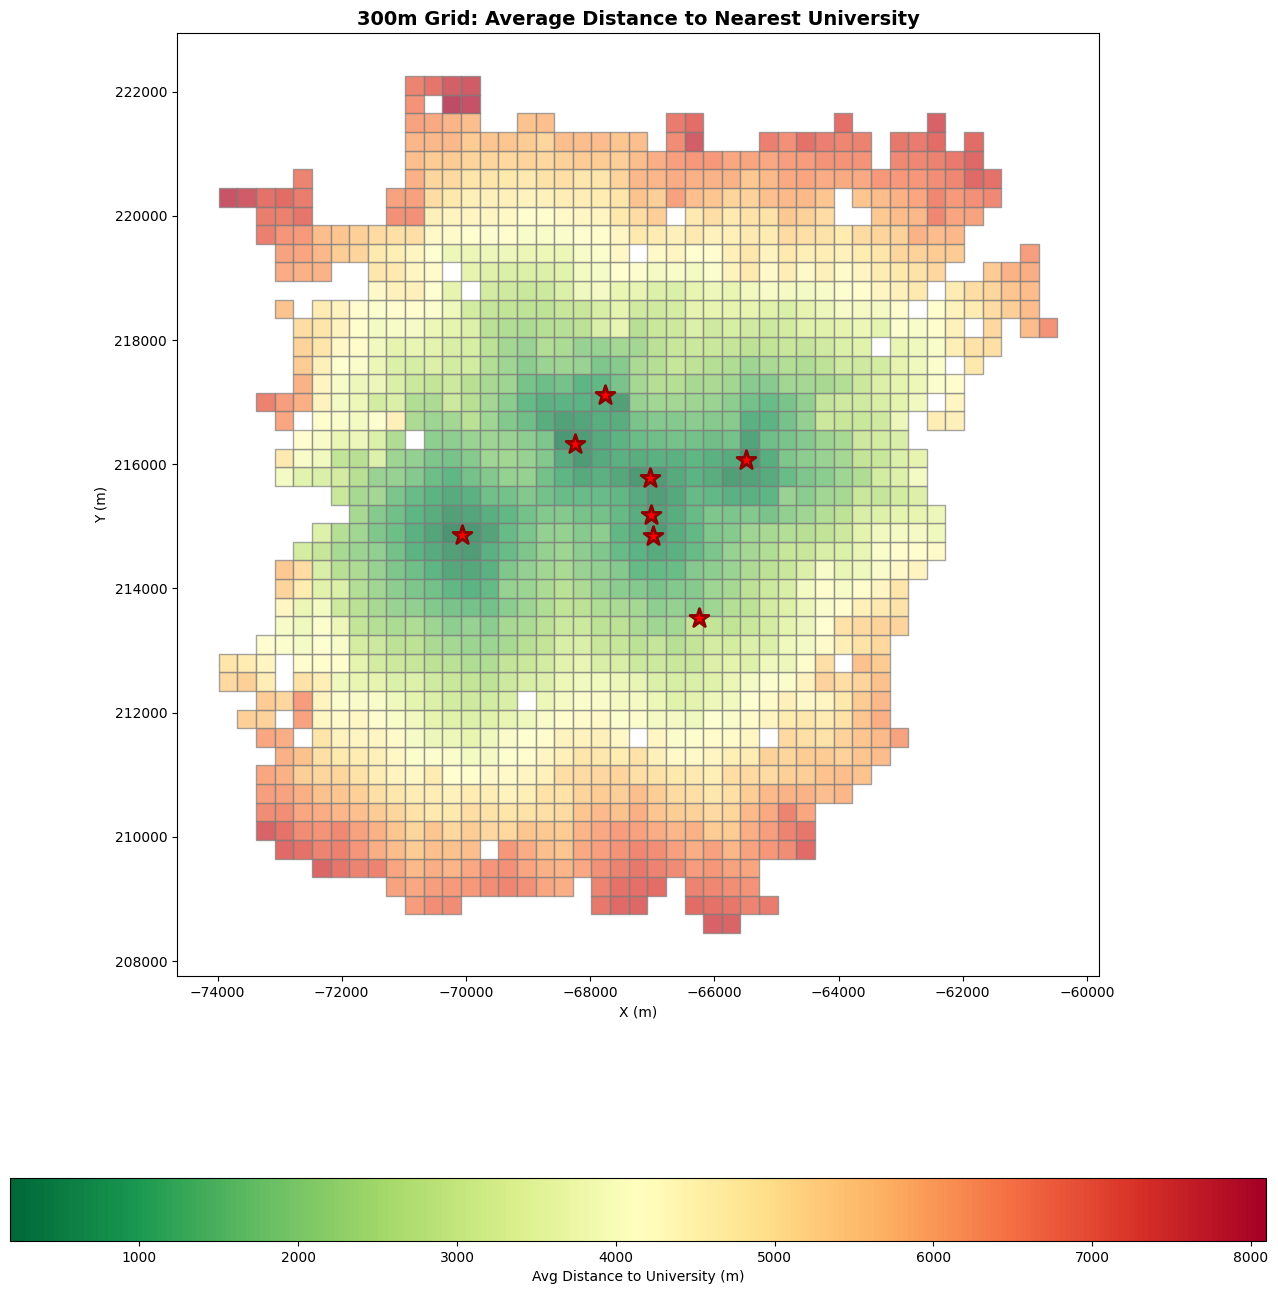

Grid analysis complete.



In [ ]:
# GRID ANALYSIS: 300m grid routing (OPTIMIZED with pre-computed paths)
print("="*60)
print("GRID-BASED ROUTING ANALYSIS (300m grid)")
print("="*60)

# Create 300m grid over Graz
from shapely.geometry import box
import numpy as np

city_bounds = df_districts.geometry.total_bounds  # (minx, miny, maxx, maxy)
grid_size = 300  # 300 meters

# Generate grid cells
grid_cells = []
cell_id = 0
x = city_bounds[0]
while x < city_bounds[2]:
    y = city_bounds[1]
    while y < city_bounds[3]:
        grid_cells.append({
            'cell_id': cell_id,
            'geometry': box(x, y, x + grid_size, y + grid_size)
        })
        cell_id += 1
        y += grid_size
    x += grid_size

gdf_grid = gpd.GeoDataFrame(grid_cells, crs=main_crs)
print(f"Created {len(gdf_grid)} grid cells of {grid_size}m × {grid_size}m")

# Spatial join: find nodes in each grid cell 
print("\nMapping nodes to grid cells...")
nodes_gdf = gpd.GeoDataFrame(
    geometry=[Point(data['x'], data['y']) for node, data in G_simple.nodes(data=True)],
    crs=main_crs
)
nodes_gdf['node_id'] = list(G_simple.nodes())

# Spatial join 
node_grid_join = gpd.sjoin(nodes_gdf, gdf_grid, how='inner', predicate='within')
print(f"Assigned {len(node_grid_join)} nodes to grid cells")

# Route all nodes to nearest university
print("\nRouting nodes to nearest university (length-based)...")
grid_results = {}

for cell_id in gdf_grid['cell_id'].unique():
    nodes_in_cell = node_grid_join[node_grid_join['cell_id'] == cell_id]['node_id'].tolist()
    
    if len(nodes_in_cell) == 0:
        continue
    
    distances = []
    for origin_node in nodes_in_cell:
        result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='length')
        if result:
            distances.append(result['cost'])
    
    if distances:
        grid_results[cell_id] = {
            'num_nodes': len(nodes_in_cell),
            'avg_distance_m': np.mean(distances),
            'min_distance_m': np.min(distances),
            'max_distance_m': np.max(distances),
        }

print(f"Processed {len(grid_results)} grid cells with nodes")

# Add grid results to GeoDataFrame
gdf_grid['avg_distance'] = gdf_grid['cell_id'].map(
    lambda x: grid_results.get(x, {}).get('avg_distance_m', 0)
)
gdf_grid_with_data = gdf_grid[gdf_grid['avg_distance'] > 0]

print(f"\n{'='*60}")
print(f"Grid cells with routing data: {len(gdf_grid_with_data)}")
print(f"{'='*60}\n")

# Visualization: Grid with distance gradient
print("Creating grid visualization...")
fig, ax = plt.subplots(figsize=(16, 14))

gdf_grid_with_data.plot(
    ax=ax,
    column='avg_distance',
    cmap='RdYlGn_r',
    edgecolor='gray',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Distance to University (m)', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')

ax.set_title('300m Grid: Average Distance to Nearest University', fontsize=14, fontweight='bold')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.tight_layout()
plt.show()

print("Grid analysis complete.\n")


WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid)
Using weighted cost function (speed + tramway + slope penalties)

Routing nodes to nearest university (weighted cost)...
Processed 1393 grid cells with nodes (weighted)

Grid cells with weighted routing data: 1393

Creating weighted grid visualization...


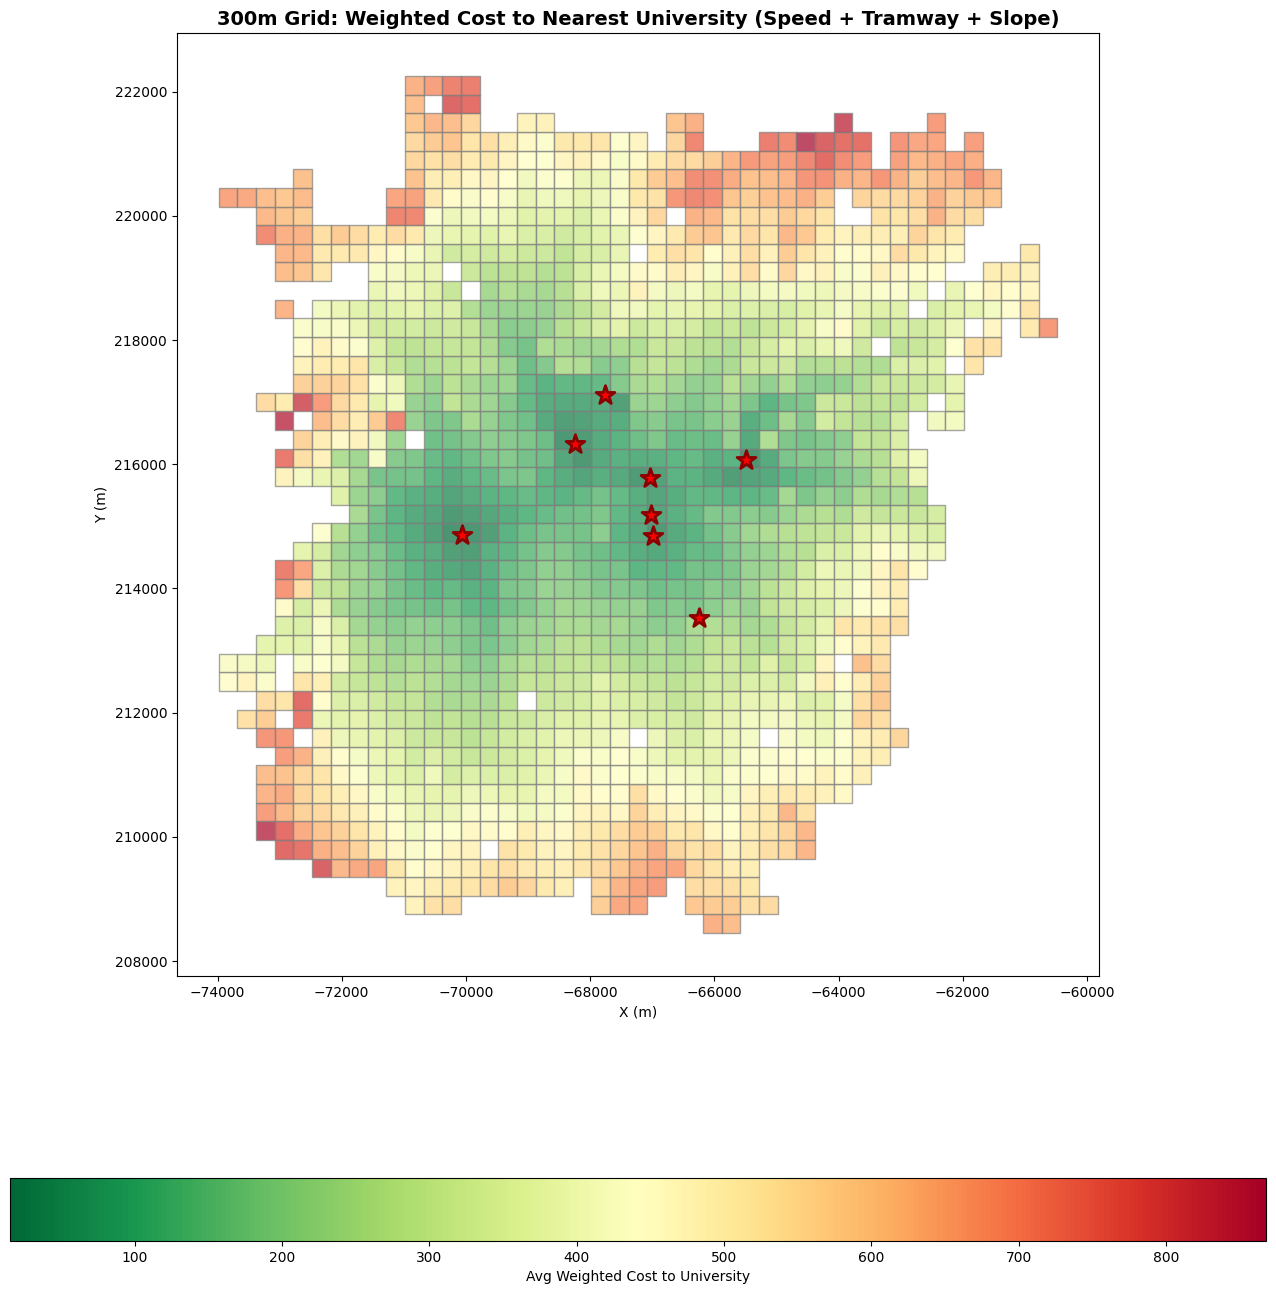


Grid comparison: Length-based vs Weighted Routing

Grid statistics (sample of 10 cells):
 Cell ID  Avg Distance (m)  Avg Weighted Cost  Cost/Distance Ratio
     105       5266.207226         446.081147             0.084706
     106       5021.224242         422.734067             0.084189
     131       7886.725853         672.746845             0.085301
     149       5494.107179         542.645658             0.098769
     151       5479.910133         482.160120             0.087987
     152       4808.880668         409.996638             0.085258
     177       7713.749137         663.628652             0.086032
     189       7524.357067         857.512886             0.113965
     190       6731.042959         688.074378             0.102224
     191       6407.062302         642.064650             0.100212

Overall statistics:
  Avg Distance (all grids): 3915.82 m
  Avg Weighted Cost (all grids): 364.52
  Avg Cost/Distance Ratio: 0.094

Weighted grid analysis complete.



In [ ]:
# WEIGHTED GRID ANALYSIS: 300m grid with weighted routing (speed, tramway, slope)
print("="*60)
print("WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid)")
print("="*60)

# Route all nodes to nearest university using weighted cost
print("Routing nodes to nearest university (weighted cost)...")
grid_results_weighted = {}

for cell_id in gdf_grid['cell_id'].unique():
    nodes_in_cell = node_grid_join[node_grid_join['cell_id'] == cell_id]['node_id'].tolist()
    
    if len(nodes_in_cell) == 0:
        continue
    
    costs = []
    for origin_node in nodes_in_cell:
        result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='weighted_cost')
        if result:
            costs.append(result['cost'])
    
    if costs:
        grid_results_weighted[cell_id] = {
            'num_nodes': len(nodes_in_cell),
            'avg_weighted_cost': np.mean(costs),
            'min_weighted_cost': np.min(costs),
            'max_weighted_cost': np.max(costs),
        }

print(f"Processed {len(grid_results_weighted)} grid cells with nodes (weighted)")

# Add weighted results to GeoDataFrame
gdf_grid['avg_weighted_cost'] = gdf_grid['cell_id'].map(
    lambda x: grid_results_weighted.get(x, {}).get('avg_weighted_cost', 0)
)
gdf_grid_weighted_with_data = gdf_grid[gdf_grid['avg_weighted_cost'] > 0]

print(f"\n{'='*60}")
print(f"Grid cells with weighted routing data: {len(gdf_grid_weighted_with_data)}")
print(f"{'='*60}\n")

# Visualization: Weighted grid with cost gradient
print("Creating weighted grid visualization...")
fig, ax = plt.subplots(figsize=(16, 14))

gdf_grid_weighted_with_data.plot(
    ax=ax,
    column='avg_weighted_cost',
    cmap='RdYlGn_r',
    edgecolor='gray',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Weighted Cost to University', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')

ax.set_title('300m Grid: Weighted Cost to Nearest University (Speed + Tramway + Slope)', fontsize=14, fontweight='bold')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.tight_layout()
plt.show()

print("\nWeighted grid analysis complete.\n")


In [ ]:
# LENGTH-BASED ROUTING: Districts using pre-computed distance maps 
print("="*60)
print("LENGTH-BASED ROUTING ANALYSIS FOR DISTRICTS")
print("="*60)

district_results = {}

for district in valid_districts:
    district_name = district["name"]
    print(f"Routing for district: {district_name}")

    try:
        district_geom = district.geometry

        G_district = ox.truncate.truncate_graph_polygon(
            G_simple,
            district_geom,
            truncate_by_edge=True
        )

        nodes_in_district = list(G_district.nodes)
        
        if len(nodes_in_district) == 0:
            print(f"  No nodes in district '{district_name}', skipping")
            continue

        print(f"  {len(nodes_in_district)} nodes in district")

        # Use pre-computed paths (no network calls needed)
        routes_data = []
        distances = []

        for origin_node in nodes_in_district:
            # Use pre-computed length-based paths 
            result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='length')
            
            if result:
                routes_data.append({
                    'origin_node': origin_node,
                    'uni_node': result['uni_node'],
                    'distance_m': result['cost'],
                    'district': district_name,
                    'path': result['path']
                })
                distances.append(result['cost'])

        if distances:
            print(f"  Successfully routed {len(routes_data)}/{len(nodes_in_district)} nodes (length-based)")
            district_results[district_name] = {
                'total_routes': len(routes_data),
                'avg_distance_m': np.mean(distances),
                'min_distance_m': np.min(distances),
                'max_distance_m': np.max(distances),
                'routes': routes_data
            }
    
    except Exception as e:
        print(f"  Error processing district '{district_name}': {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"Total districts processed (length-based): {len(district_results)}")
print(f"{'='*60}\n")


LENGTH-BASED ROUTING ANALYSIS FOR DISTRICTS
Routing for district: Innere Stadt
  762 nodes in district
  Successfully routed 616/762 nodes (length-based)
Routing for district: Liebenau
  1507 nodes in district
  Successfully routed 1349/1507 nodes (length-based)
Routing for district: Sankt Leonhard
  1047 nodes in district
  Successfully routed 1005/1047 nodes (length-based)
Routing for district: Geidorf
  1866 nodes in district
  Successfully routed 1783/1866 nodes (length-based)
Routing for district: Lend
  1404 nodes in district
  Successfully routed 1352/1404 nodes (length-based)
Routing for district: Gries
  1760 nodes in district
  Successfully routed 1594/1760 nodes (length-based)
Routing for district: Jakomini
  1472 nodes in district
  Successfully routed 1431/1472 nodes (length-based)
Routing for district: Sankt Peter
  1742 nodes in district
  Successfully routed 1613/1742 nodes (length-based)
Routing for district: Waltendorf
  1094 nodes in district
  Successfully routed 98

In [ ]:
# Create summary dataframe
summary_df = pd.DataFrame([
    {
        'District': district_name,
        'Total Routes': stats['total_routes'],
        'Avg Distance (m)': stats['avg_distance_m'],
        'Min Distance (m)': stats['min_distance_m'],
        'Max Distance (m)': stats['max_distance_m'],
    }
    for district_name, stats in district_results.items()
])

print("\nDistrict Summary:")
print(summary_df.to_string())

# summary_df.to_csv("district_routes_summary.csv", index=False)


District Summary:
          District  Total Routes  Avg Distance (m)  Min Distance (m)  Max Distance (m)
0     Innere Stadt           616       1174.467978        416.137102       2087.043828
1         Liebenau          1349       4955.258790       2890.167236       7699.265482
2   Sankt Leonhard          1005        947.302361          0.000000       2359.539995
3          Geidorf          1783       1038.033839          0.000000       2494.548865
4             Lend          1352       1414.774987         96.991960       2928.798827
5            Gries          1594       2304.604020          0.000000       4529.384555
6         Jakomini          1431       2071.313479          0.000000       3951.947984
7      Sankt Peter          1613       4201.812660       2069.919387       6690.080107
8       Waltendorf           987       2380.818441        316.771737       4849.831060
9             Ries           940       2595.979427          0.000000       6665.767872
10      Mariatrost      

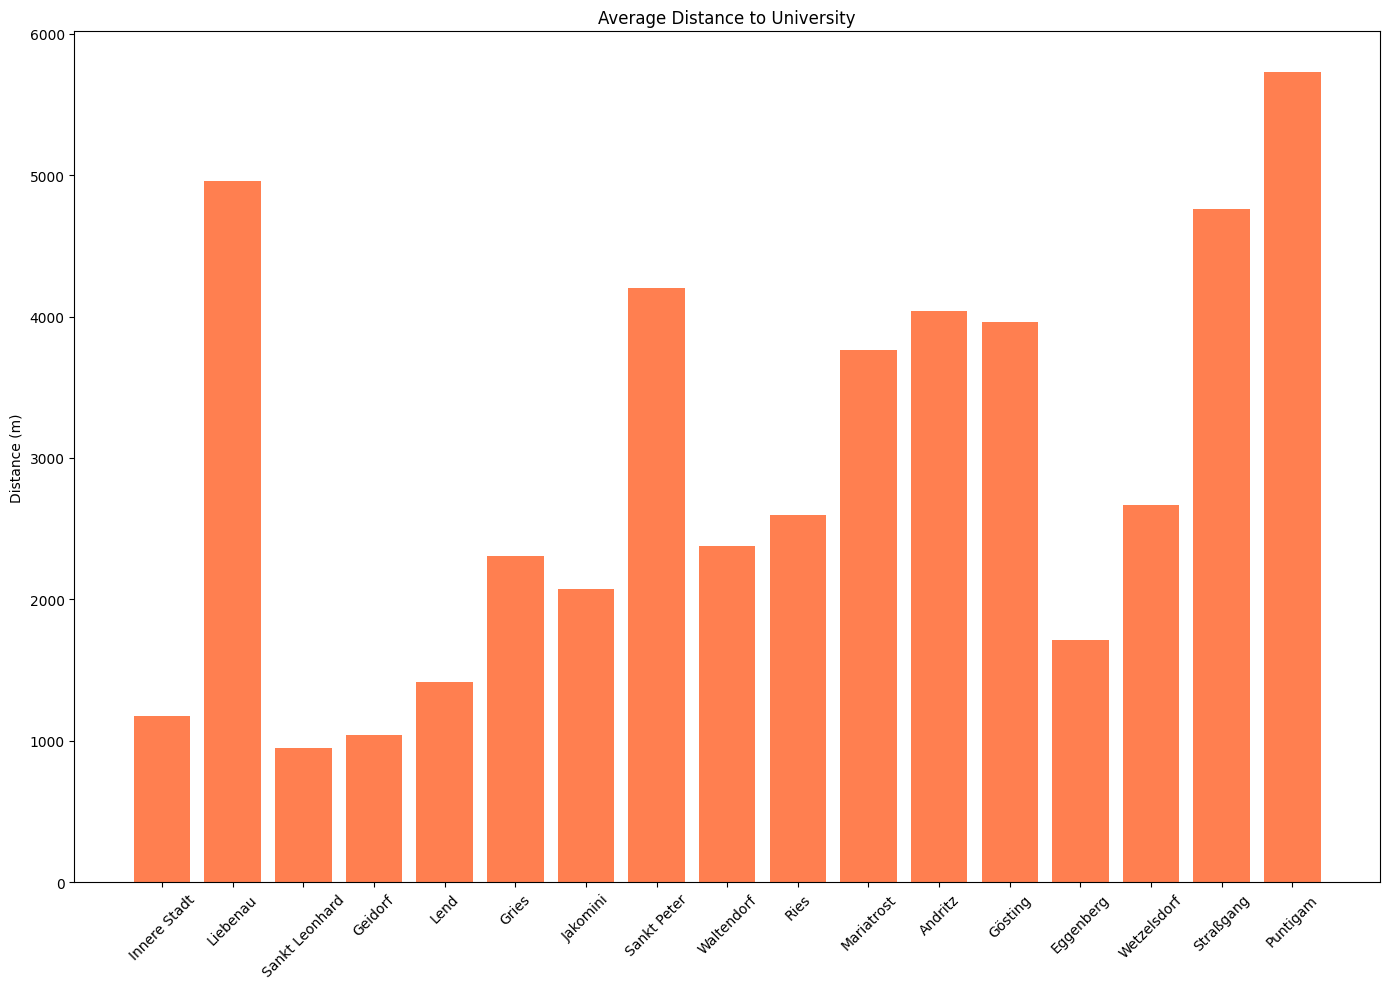

In [50]:
# Visualization 1: Bar charts for district statistics
fig, axes = plt.subplots(figsize=(14, 10))

plt.bar(summary_df['District'], summary_df['Avg Distance (m)'], color='coral')
plt.title('Average Distance to University')
plt.ylabel('Distance (m)')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

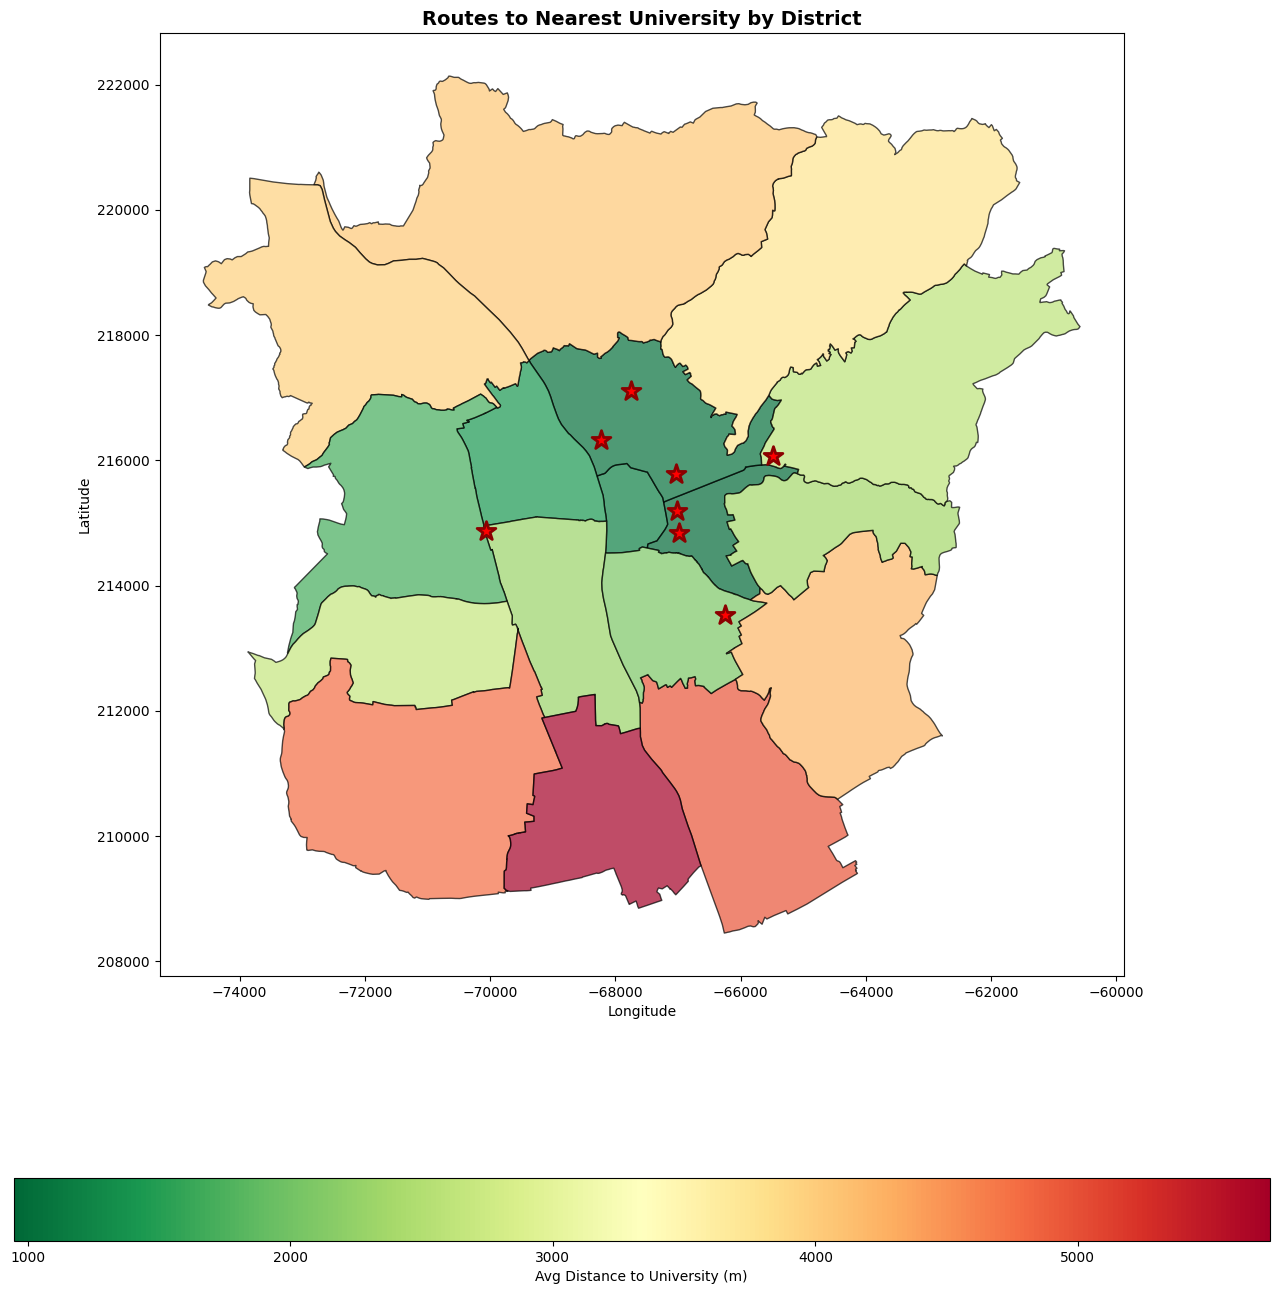

In [51]:
# Visualization 2: Map of routes by district
fig, ax = plt.subplots(figsize=(16, 14))

# Plot districts with color gradient based on average distance
df_districts_with_stats = df_districts.copy()
df_districts_with_stats['avg_distance'] = df_districts_with_stats['name'].map(
    lambda x: district_results.get(x, {}).get('avg_distance_m', 0)
)

df_districts_with_stats = df_districts_with_stats[df_districts_with_stats['avg_distance'] > 0]
df_districts_with_stats.plot(
    ax=ax,
    column='avg_distance',
    cmap='RdYlGn_r',
    edgecolor='black',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Distance to University (m)', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')


ax.set_title('Routes to Nearest University by District', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
# WEIGHTED ROUTING: Districts with custom cost function (speed, tramway, slope)
# Uses pre-computed distance maps from Setup cell
print("="*60)
print("WEIGHTED ROUTING ANALYSIS FOR DISTRICTS")
print("="*60)
print(f"Using {len(all_uni_node_ids)} universities for routing\n")

# Step 1: Process districts with weighted routing 
print("Processing districts with weighted costs...")
district_results_weighted = {}

for district in valid_districts:
    district_name = district["name"]
    print(f"Weighted routing for district: {district_name}")

    try:
        district_geom = district.geometry
        G_district = ox.truncate.truncate_graph_polygon(
            G_simple,
            district_geom,
            truncate_by_edge=True
        )

        nodes_in_district = list(G_district.nodes)
        
        if len(nodes_in_district) == 0:
            print(f"  No nodes in district '{district_name}', skipping")
            continue

        print(f"  {len(nodes_in_district)} nodes in district")

        # Use pre-computed paths 
        routes_data = []
        costs = []

        for origin_node in nodes_in_district:
            result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='weighted_cost')
            
            if result:
                routes_data.append({
                    'origin_node': origin_node,
                    'uni_node': result['uni_node'],
                    'weighted_cost': result['cost'],
                    'path': result['path'],
                    'district': district_name
                })
                costs.append(result['cost'])

        if costs:
            print(f"  Successfully routed {len(routes_data)}/{len(nodes_in_district)} nodes (weighted)")
            district_results_weighted[district_name] = {
                'total_routes': len(routes_data),
                'avg_weighted_cost': np.mean(costs),
                'min_weighted_cost': np.min(costs),
                'max_weighted_cost': np.max(costs),
                'routes': routes_data
            }
    
    except Exception as e:
        print(f"  Error processing district '{district_name}': {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"Total districts processed (weighted): {len(district_results_weighted)}")
print(f"{'='*60}\n")


WEIGHTED ROUTING ANALYSIS FOR DISTRICTS
Using 8 universities for routing

Processing districts with weighted costs...
Weighted routing for district: Innere Stadt
  762 nodes in district
  Successfully routed 616/762 nodes (weighted)
Weighted routing for district: Liebenau
  1507 nodes in district
  Successfully routed 1349/1507 nodes (weighted)
Weighted routing for district: Sankt Leonhard
  1047 nodes in district
  Successfully routed 1005/1047 nodes (weighted)
Weighted routing for district: Geidorf
  1866 nodes in district
  Successfully routed 1783/1866 nodes (weighted)
Weighted routing for district: Lend
  1404 nodes in district
  Successfully routed 1352/1404 nodes (weighted)
Weighted routing for district: Gries
  1760 nodes in district
  Successfully routed 1594/1760 nodes (weighted)
Weighted routing for district: Jakomini
  1472 nodes in district
  Successfully routed 1431/1472 nodes (weighted)
Weighted routing for district: Sankt Peter
  1742 nodes in district
  Successfully ro


Creating weighted routing map visualization...


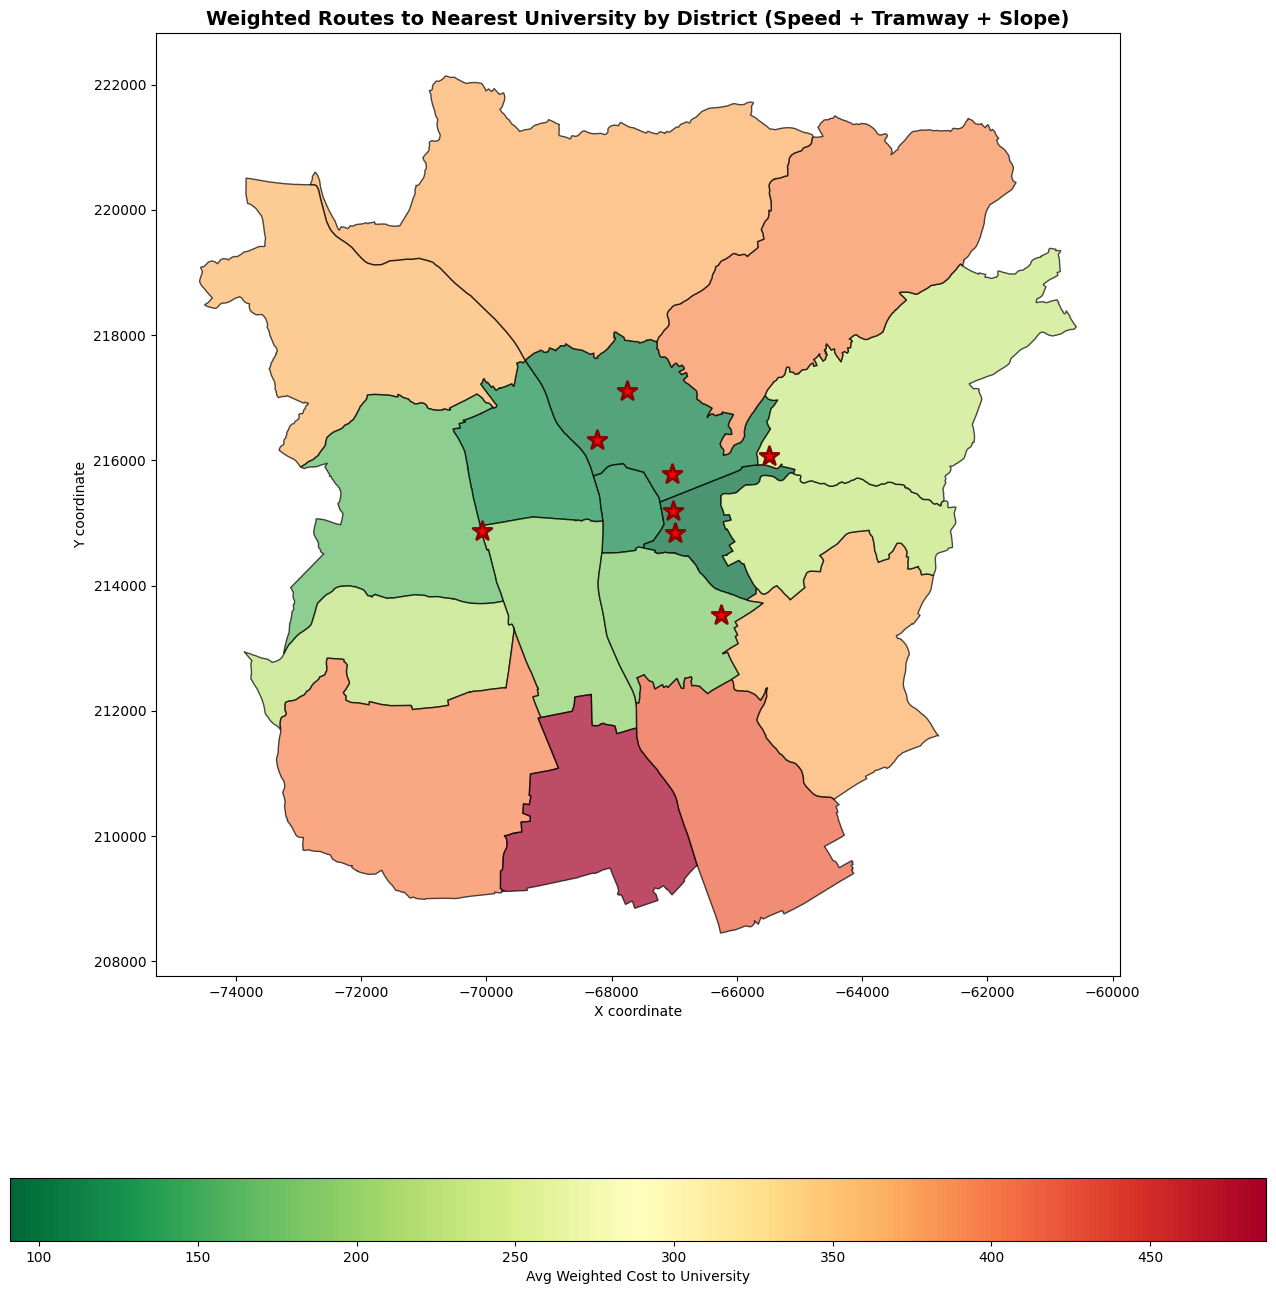

In [53]:
# Visualization 3: Map of weighted routes by district
print("\nCreating weighted routing map visualization...")
fig, ax = plt.subplots(figsize=(16, 14))

# Plot districts with color gradient based on WEIGHTED COST
df_districts_weighted_stats = df_districts.copy()
df_districts_weighted_stats['avg_weighted_cost'] = df_districts_weighted_stats['name'].map(
    lambda x: district_results_weighted.get(x, {}).get('avg_weighted_cost', 0)
)

df_districts_weighted_stats = df_districts_weighted_stats[df_districts_weighted_stats['avg_weighted_cost'] > 0]
df_districts_weighted_stats.plot(
    ax=ax,
    column='avg_weighted_cost',
    cmap='RdYlGn_r',
    edgecolor='black',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Weighted Cost to University', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')

ax.set_title('Weighted Routes to Nearest University by District (Speed + Tramway + Slope)', fontsize=14, fontweight='bold')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.tight_layout()
plt.show()

